## Assignment 2 

Authors: Catherine Slaughter and Paloma Jol of Group 23  
Assignment 2 of the course introduction to machine learning (IML)  
Due: 23 december 2022 23:59


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import astropy
import astropy.units as u
import astropy.coordinates as coord

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN



from sklearn import tree
from sklearn import ensemble

2022-12-22 10:35:56.637174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Start pre-processing data, and exploring data analysis

In [28]:
def read_in_data(filename = 'data/A2_data.csv'):
    '''Reads in the data from the given csv, and saves it in a Pandas dataframe'''
    df = pd.read_csv(filename)
    X,y= df.loc[:, df.columns != 'class'], df['class']
    return df, X, y

def train_test_split_drop(X,y, test_size : float, random_state=42, drop=True):
    '''Split the test and training data using a random state, if drop is True the index are reset after'''
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state=42)
    X_train,y_train=X_train.reset_index(drop=drop),y_train.reset_index(drop=drop)
    X_test,y_test=X_test.reset_index(drop=drop),y_test.reset_index(drop=drop)
    return X_train, X_test, y_train, y_test

def histogram(column):
    '''Plot the histograms of the features'''
    plt.hist(X[column],facecolor='blue', alpha=0.8,histtype='bar', ec='black')
    plt.title(column)
    plt.xlabel('Feature label')
    plt.ylabel('Number of samples')
    plt.show()


There are 100000 samples of each 11 features


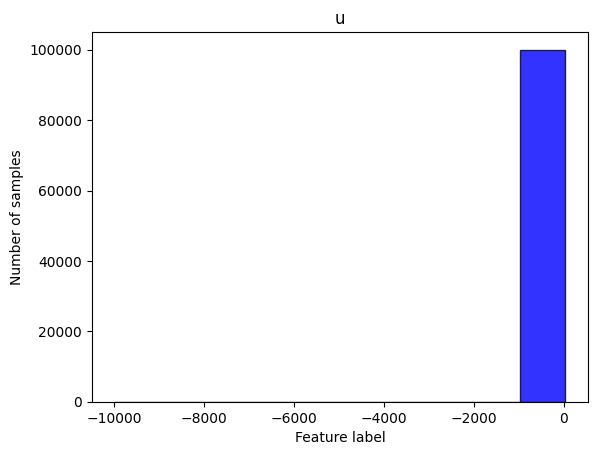

            alpha     delta       u       g        r         i       z  \
79543  224.006526 -0.624304 -9999.0 -9999.0  18.1656  18.01675 -9999.0   

       field_ID    MJD  redshift  plate class  
79543       537  58146     1.828   7834  STAR  
There are final 99999 samples of now 6 features
There are 66999 training samples of each 6 features


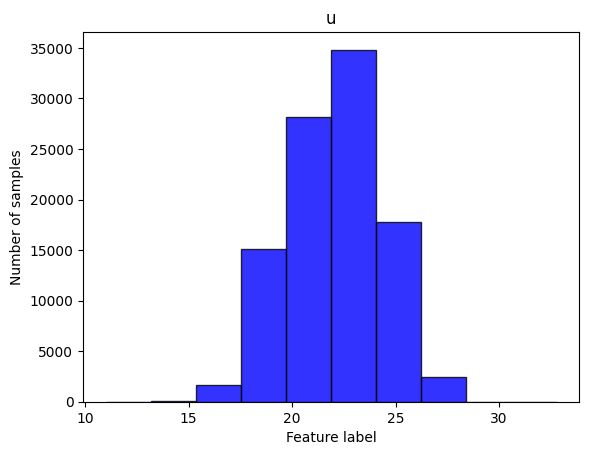

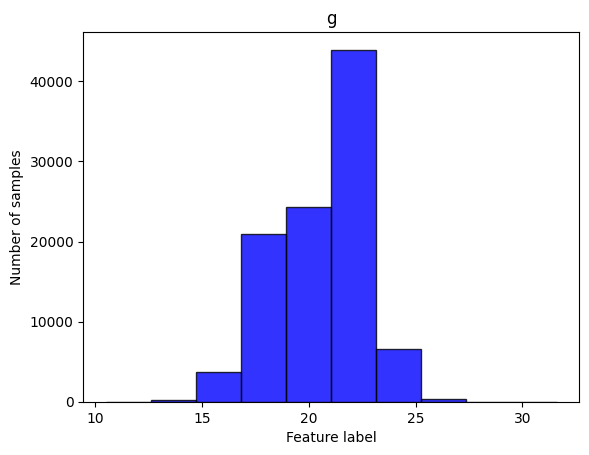

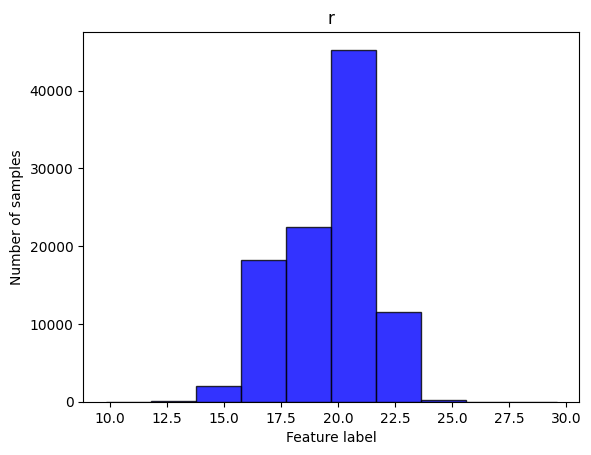

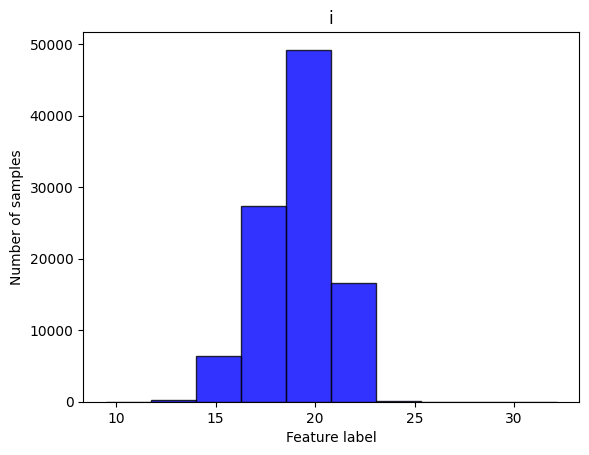

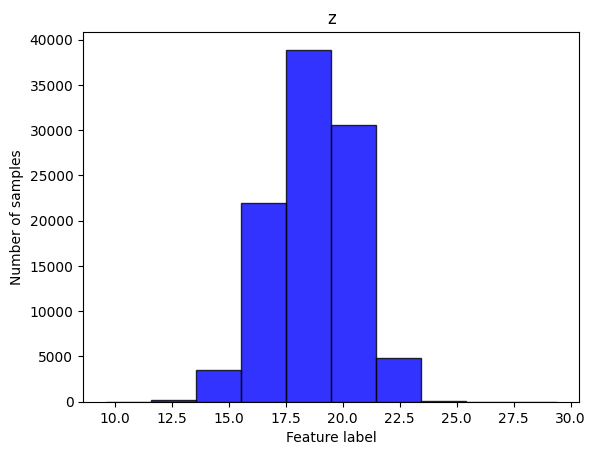

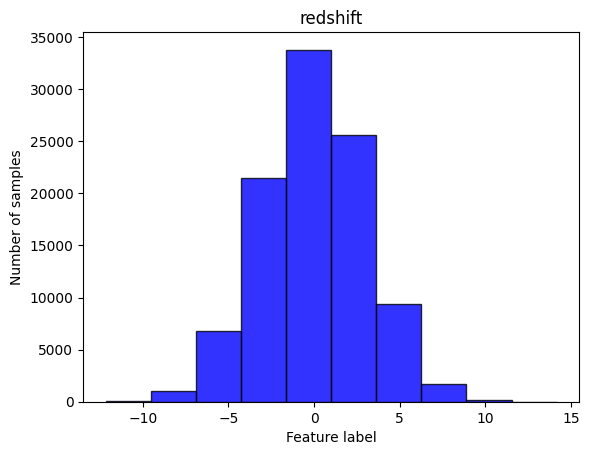

In [30]:
path = "data/"

data, X, y =read_in_data(path+'A2_data.csv')

print(f'There are {X.shape[0]} samples of each {X.shape[1]} features')

#Data includes some identifiers lets remove those 
ID_parameters= ['field_ID','MJD','plate','alpha', 'delta']
for ID in ID_parameters:
    X=X.loc[:, X.columns != ID]

histogram('u')

#We know that a flux should be positive so remove the datapoint which does not have that
#This datapoint has value -9999 so not a detection but a instrumentation issue
I_remove=np.where(X['u']<0)[0]
print(data.loc[I_remove])
X,y = X.drop(I_remove),y.drop(I_remove)
X,y=X.reset_index(drop=True),y.reset_index(drop=True)
data_processed= X.join(y)
data_processed.to_csv(path+'A2_data_preprocessed.csv', index=False)


print(f'There are final {X.shape[0]} samples of now {X.shape[1]} features')

X_train, X_test, y_train, y_test = train_test_split_drop(X,y, test_size=0.33, random_state=42, drop=True)


print(f'There are {X_train.shape[0]} training samples of each {X_train.shape[1]} features')

for C in X.columns:
    histogram(C)

Start dimensionality reductions

In [37]:
#Visualise the dimension models
def visualise_components(model_name, y, finaldim, save=False):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title(f'2 component {model_name}', fontsize = 20)
    targets = np.unique(y)
    colors = ['r', 'g', 'b','k','y']
    for target, color in zip(targets,colors):
        indicesToKeep = finaldim['class'] == target
        ax.scatter(finaldim.loc[indicesToKeep, 'component 1']
                , finaldim.loc[indicesToKeep, 'component 2']
                , c = color
                , s = 10
                , marker = '.'
                , alpha=0.2)
    ax.legend(targets, fontsize=15)
    ax.grid()
    if save == True:
        plt.savefig(f'plots/{model_name}.pdf')
    plt.show()

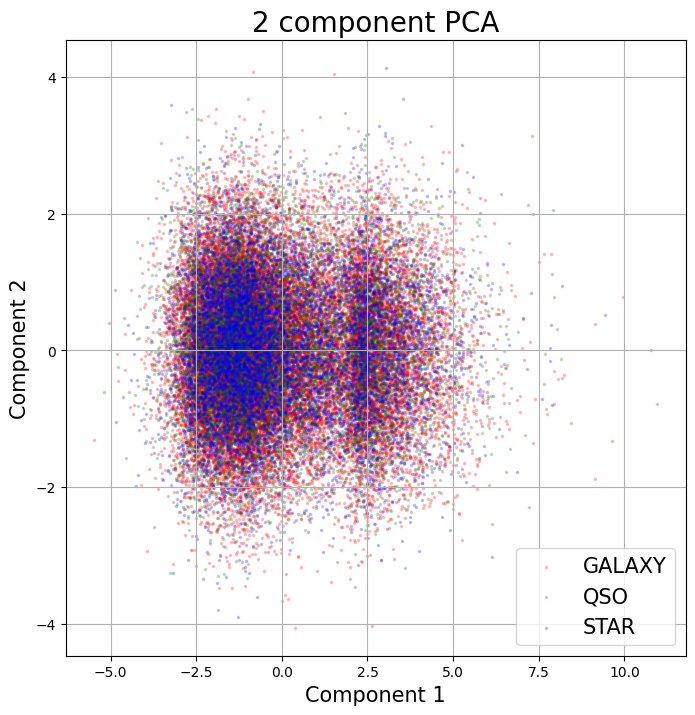

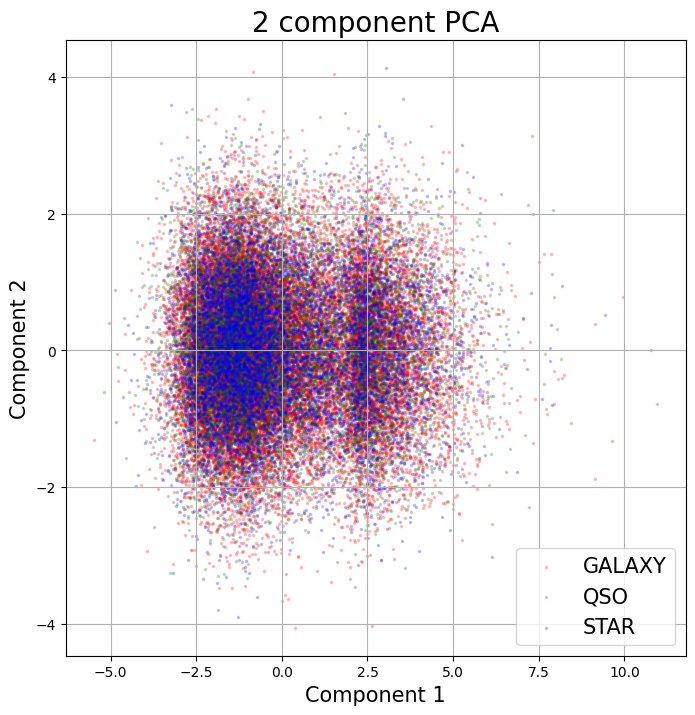

In [9]:
#Load in preprocessed data
path = "data/"
preprocessed, X, y = read_in_data(path+'A2_data_preprocessed.csv')
X_train, X_test, y_train, y_test = train_test_split_drop(X,y, test_size=0.33, random_state=42, drop=True) #random state chosen for reproducable results

x = X_train
x = StandardScaler().fit_transform(x)

params_list=[{
    "n_components": 2,
    "svd_solver": 'auto'
},{
     "n_components": 5,
    "svd_solver": 'auto'
}]


# Use PCA to reduce to two and to five dimensions for testing in RF
for params in params_list:
    pca = PCA(**params)
    c = params['n_components']
    principalComponents = pca.fit_transform(x)
    principal = pd.DataFrame(data = principalComponents,columns = np.array([f'component {i}' for i in range(1,c+1)],dtype=str))
    finalPca = pd.concat([principal, y_train], axis = 1)

    visualise_components('PCA', y_train, finalPca) #only the first two components are shown for the five components

    finalPca.to_csv(f'PCA_reduced_{c}_alphadelta.csv', index=False)

In [ ]:
#Experiments run on UMAP since this method had visaully the best results and was faster to run than TSNE
params_list=[{
    "n_neighbors": 2,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 5,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 50,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 100,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 200,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.0,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.1,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.25,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.4,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.45,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.5,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "euclidean", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "minkowski", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "mahalanobis", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "jaccard", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "chebyshev", 
    "init": "random"
}]

10


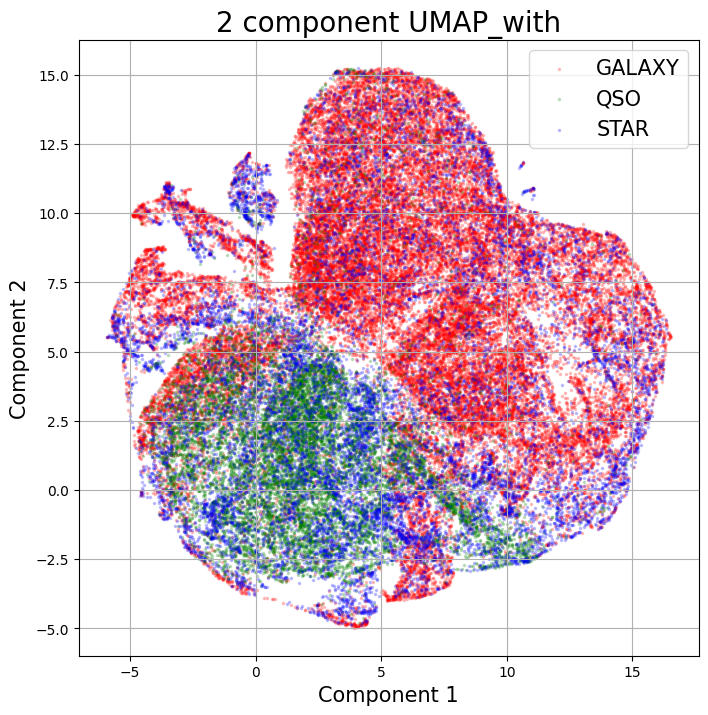

10


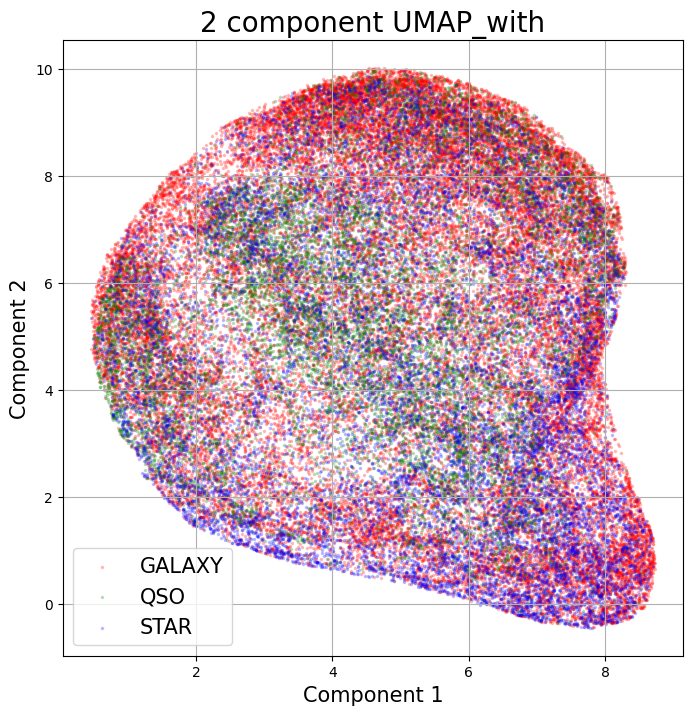

In [28]:
#UMAP
#best parameters from experiments
params_list=[{
    "n_components": 2,
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
},{
    "n_components": 5,
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
}]
for params in params_list:
    print(params['n_neighbors'])
    x = X_train
    x = StandardScaler().fit_transform(x)
    c = params['n_components']
    reducer = umap.UMAP(**params)
    UmapComponents = reducer.fit_transform(x)
    UmapDf = pd.DataFrame(data = UmapComponents,columns = np.array([f'component {i}' for i in range(1,c+1)],dtype=str))
    finalUmapDf = pd.concat([UmapDf, y_train], axis = 1)
    visualise_components(f"UMAP", y_train, finalUmapDf)
    finalUmapDf.to_csv(f'Umap_reduced_data_with_{c}.csv', index=False)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 66999 samples in 0.118s...
[t-SNE] Computed neighbors for 66999 samples in 2.219s...
[t-SNE] Computed conditional probabilities for sample 1000 / 66999
[t-SNE] Computed conditional probabilities for sample 2000 / 66999
[t-SNE] Computed conditional probabilities for sample 3000 / 66999
[t-SNE] Computed conditional probabilities for sample 4000 / 66999
[t-SNE] Computed conditional probabilities for sample 5000 / 66999
[t-SNE] Computed conditional probabilities for sample 6000 / 66999
[t-SNE] Computed conditional probabilities for sample 7000 / 66999
[t-SNE] Computed conditional probabilities for sample 8000 / 66999
[t-SNE] Computed conditional probabilities for sample 9000 / 66999
[t-SNE] Computed conditional probabilities for sample 10000 / 66999
[t-SNE] Computed conditional probabilities for sample 11000 / 66999
[t-SNE] Computed conditional probabilities for sample 12000 / 66999
[t-SNE] Computed conditional probabilities for sam

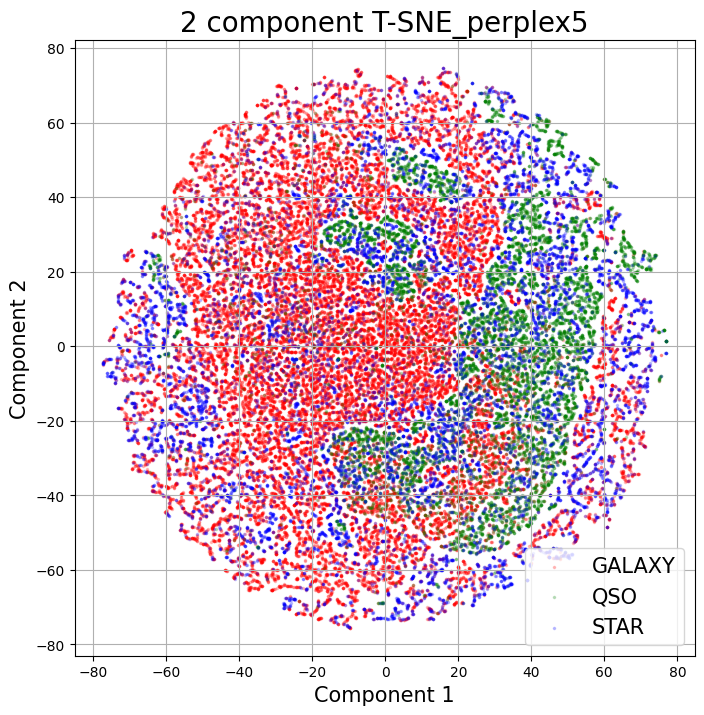

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 66999 samples in 0.059s...
[t-SNE] Computed neighbors for 66999 samples in 5.216s...
[t-SNE] Computed conditional probabilities for sample 1000 / 66999
[t-SNE] Computed conditional probabilities for sample 2000 / 66999
[t-SNE] Computed conditional probabilities for sample 3000 / 66999
[t-SNE] Computed conditional probabilities for sample 4000 / 66999
[t-SNE] Computed conditional probabilities for sample 5000 / 66999
[t-SNE] Computed conditional probabilities for sample 6000 / 66999
[t-SNE] Computed conditional probabilities for sample 7000 / 66999
[t-SNE] Computed conditional probabilities for sample 8000 / 66999
[t-SNE] Computed conditional probabilities for sample 9000 / 66999
[t-SNE] Computed conditional probabilities for sample 10000 / 66999
[t-SNE] Computed conditional probabilities for sample 11000 / 66999
[t-SNE] Computed conditional probabilities for sample 12000 / 66999
[t-SNE] Computed conditional probabilities for sam

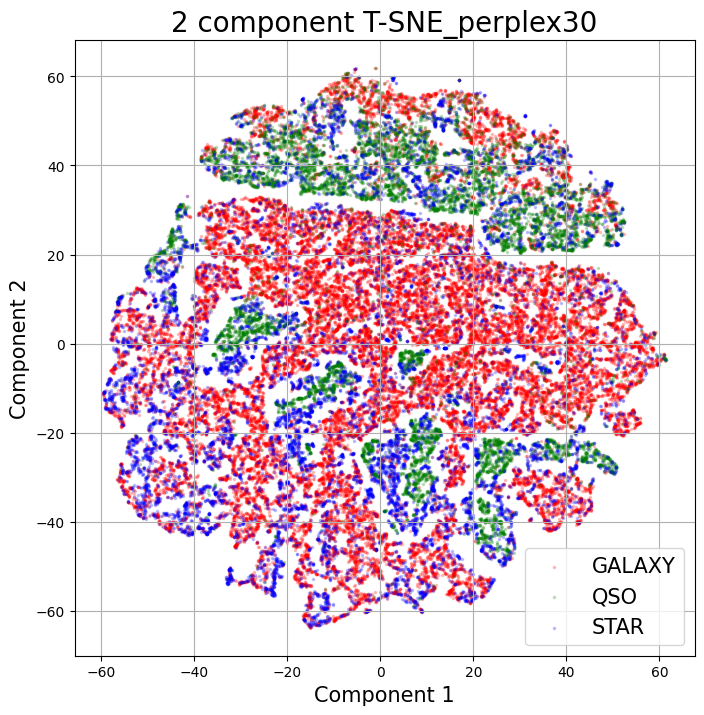

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 66999 samples in 0.055s...
[t-SNE] Computed neighbors for 66999 samples in 6.252s...
[t-SNE] Computed conditional probabilities for sample 1000 / 66999
[t-SNE] Computed conditional probabilities for sample 2000 / 66999
[t-SNE] Computed conditional probabilities for sample 3000 / 66999
[t-SNE] Computed conditional probabilities for sample 4000 / 66999
[t-SNE] Computed conditional probabilities for sample 5000 / 66999
[t-SNE] Computed conditional probabilities for sample 6000 / 66999
[t-SNE] Computed conditional probabilities for sample 7000 / 66999
[t-SNE] Computed conditional probabilities for sample 8000 / 66999
[t-SNE] Computed conditional probabilities for sample 9000 / 66999
[t-SNE] Computed conditional probabilities for sample 10000 / 66999
[t-SNE] Computed conditional probabilities for sample 11000 / 66999
[t-SNE] Computed conditional probabilities for sample 12000 / 66999
[t-SNE] Computed conditional probabilities for sa

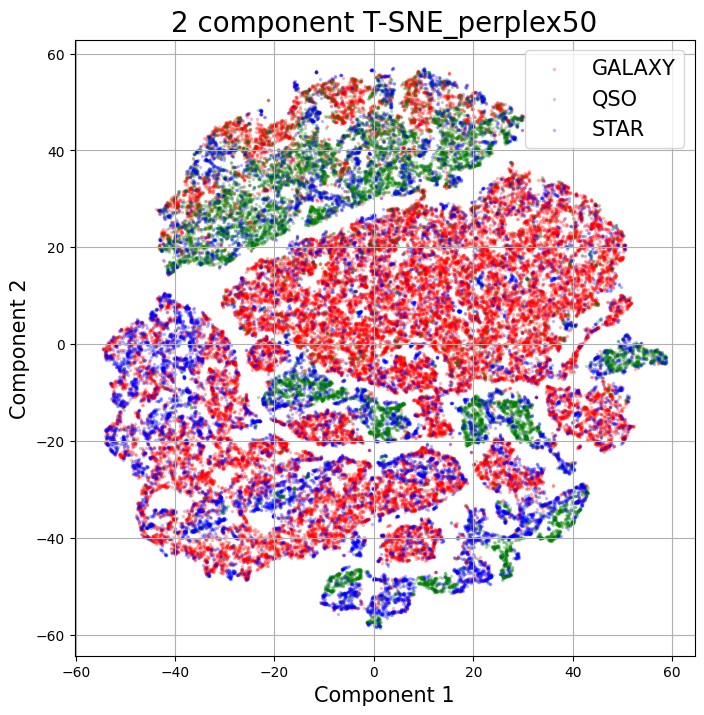

In [39]:
#Some experiments run on T-SNE to see the effect of changing perplexity
params_list=[{
    'perplexity' : 5 ,
    'early_exaggeration' : 12.0 ,
    'metric': 'euclidean'
},{
    'perplexity' : 30 ,
    'early_exaggeration' : 12.0 ,
    'metric': 'euclidean'
},{
    'perplexity' : 50 ,
    'early_exaggeration' : 12.0 ,
    'metric': 'euclidean'
}]

# Use T-SNE to reduce to two dimensions
for params in params_list:
    x = X_train
    tsne = TSNE(n_components=2, verbose=1, perplexity=params['perplexity'], early_exaggeration=params['early_exaggeration'], metric=params['metric'])
    tsneComponents = tsne.fit_transform(x)
    tsneDf = pd.DataFrame(data = tsneComponents,columns = ['component 1', 'component 2'])
    finalTsneDf = pd.concat([tsneDf, y_train], axis = 1)
    finalTsneDf

    visualise_components(f"T-SNE_perplex{params['perplexity']}", y_train, finalTsneDf)

Start clustering

In [42]:
class Cluster_object():
    def __init__(self,method):
        self.method= method 

    def cluster_fit(self,X,params):
        clustering = self.method(**params)
        clustering.fit(X)
        return clustering

    def score(self,y_pred, y):
        nmis=0 #number misclassified
        for i in range(len(y_pred)):
            if y_pred[i] != y[i]:
                nmis+=1
        accuracy=nmis/len(y)
        print(f'Out of {len(y)} there are {nmis} missclassified samples, thus an accuracy of {accuracy}')
        return accuracy

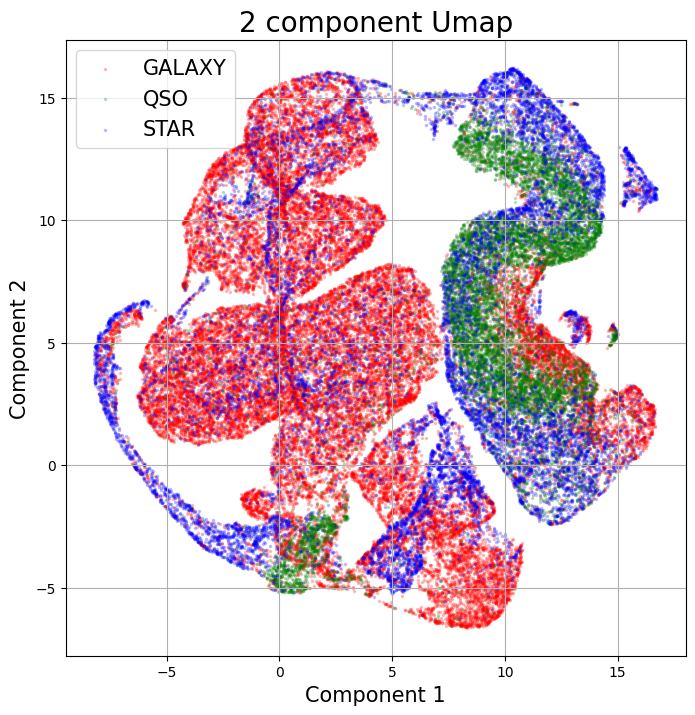

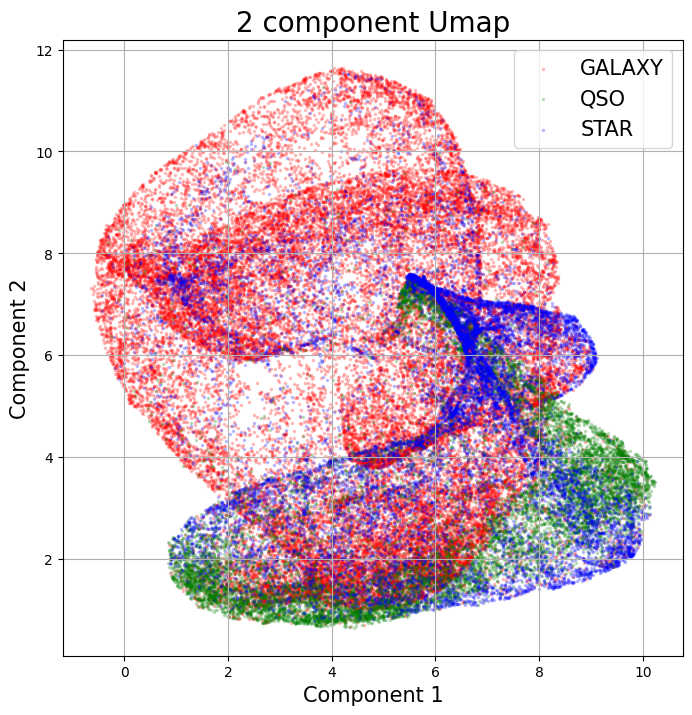

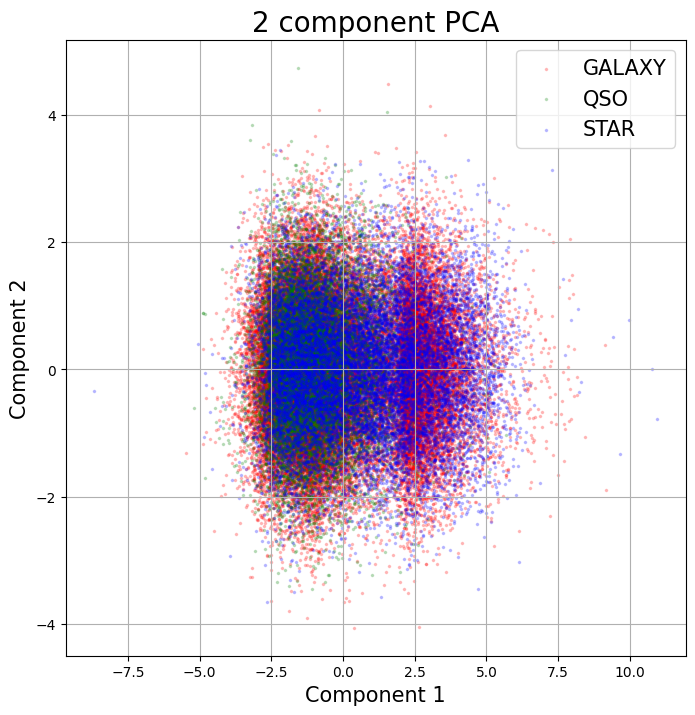

In [40]:
#Data import of dimension reduction
path='data_last/'
reduced_c2=pd.read_csv(path+'Umap_reduced_data.csv')
visualise_components('Umap', reduced_c2['class'], reduced_c2)

reduced_c5=pd.read_csv(path+'Umap_reduced_data_with_5.csv')
visualise_components('Umap', reduced_c5['class'], reduced_c5)

#reduced_pca=pd.read_csv(path+'PCA_reduced_5.csv')
#visualise_components('PCA', reduced_pca['class'], reduced_pca)


Out of 66999 there are 47339 missclassified samples, thus an accuracy of 0.706562784519172
Out of 66999 there are 54209 missclassified samples, thus an accuracy of 0.8091016283825132


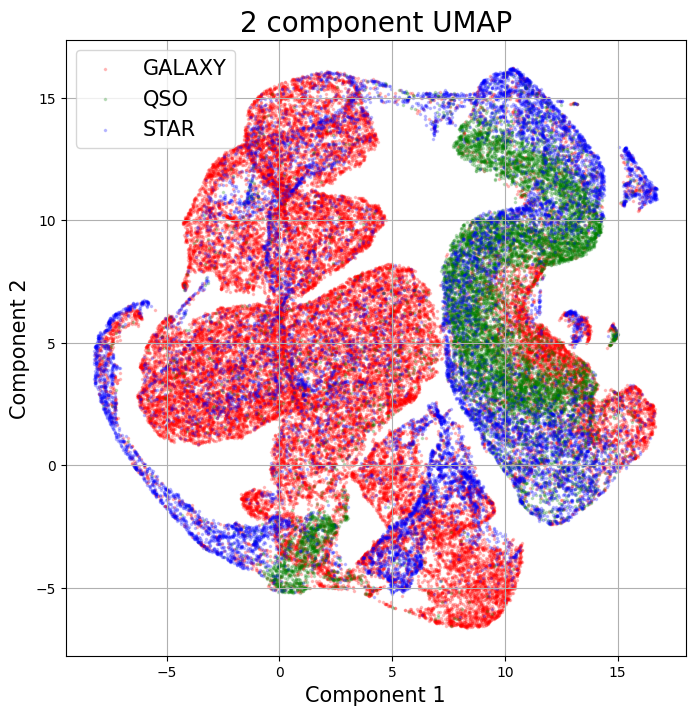

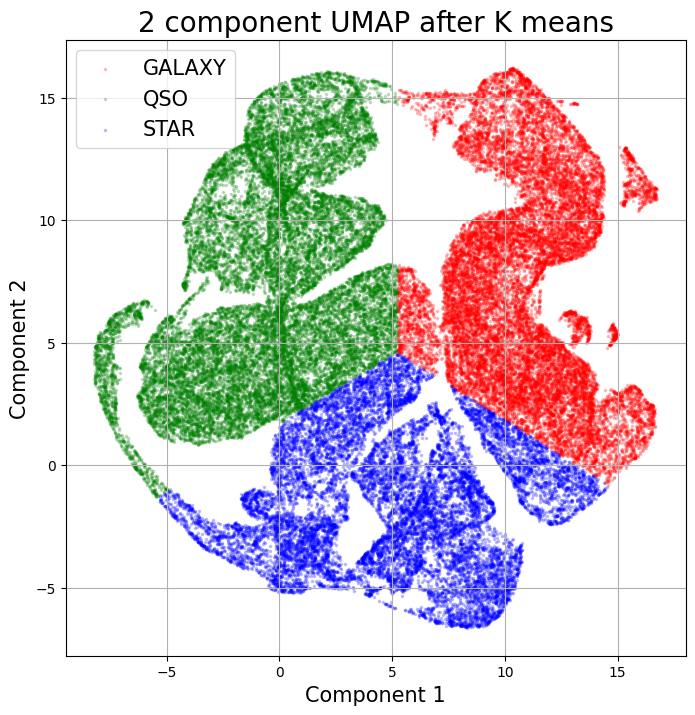

In [67]:
#Clustering the pre-processed data
path = "data/"
preprocessed, X, y = read_in_data(path+'A2_data_preprocessed.csv')
X_train, X_test, y_train, y_test = train_test_split_drop(X,y, test_size=0.33, random_state=42, drop=True) #random state chosen for reproducable results
X_scale=scale(X_train)
Class_Names=np.unique(y_train)
Kmeans=Cluster_object(KMeans)
Kmean_cluster= Kmeans.cluster_fit(X_scale,params={'n_clusters': len(Class_Names), 'random_state':4})
y_pred=Class_Names[Kmean_cluster.labels_]
Kmeans_accuracy= Kmeans.score(y_pred,y_train)
labels=pd.DataFrame(y_pred,columns=['class'])
kmeans_Df=X.join(labels)


#Clustering the reduced data
reduced_c2, X, y= read_in_data(path+'Umap_reduced_data.csv')
X_scale=scale(X)
Class_Names=np.unique(y)
Kmeans=Cluster_object(KMeans)
Kmean_cluster= Kmeans.cluster_fit(X_scale,params={'n_clusters': len(Class_Names), 'random_state':1})
y_pred=Class_Names[Kmean_cluster.labels_]
Kmeans_accuracy= Kmeans.score(y_pred,y)
labels=pd.DataFrame(y_pred,columns=['class'])
kmeans_Df_reduced=X.join(labels)

visualise_components('UMAP',Class_Names, reduced_c2, save=True)

visualise_components('UMAP after K means', Class_Names, kmeans_Df_reduced)


In [ ]:
params_list= [
{'eps':  0.001 , 'min_samples':  50.0 }, 
{'eps':  0.001 , 'min_samples':  11155.555555555555 }, 
{'eps':  0.001 , 'min_samples':  22261.11111111111 }, 
{'eps':  0.001 , 'min_samples':  33366.666666666664 }, 
{'eps':  0.001 , 'min_samples':  44472.22222222222 }, 
{'eps':  0.001 , 'min_samples':  55577.777777777774 }, 
{'eps':  0.001 , 'min_samples':  66683.33333333333 }, 
{'eps':  0.001 , 'min_samples':  77788.88888888888 }, 
{'eps':  0.001 , 'min_samples':  88894.44444444444 }, 
{'eps':  0.001 , 'min_samples':  100000.0 }, 
{'eps':  0.0064444444444444445 , 'min_samples':  50.0 }, 
{'eps':  0.0064444444444444445 , 'min_samples':  11155.555555555555 }, 
{'eps':  0.0064444444444444445 , 'min_samples':  22261.11111111111 }, 
{'eps':  0.0064444444444444445 , 'min_samples':  33366.666666666664 }, 
{'eps':  0.0064444444444444445 , 'min_samples':  44472.22222222222 }, 
{'eps':  0.0064444444444444445 , 'min_samples':  55577.777777777774 }, 
{'eps':  0.0064444444444444445 , 'min_samples':  66683.33333333333 }, 
{'eps':  0.0064444444444444445 , 'min_samples':  77788.88888888888 }, 
{'eps':  0.0064444444444444445 , 'min_samples':  88894.44444444444 }, 
{'eps':  0.0064444444444444445 , 'min_samples':  100000.0 }, 
{'eps':  0.01188888888888889 , 'min_samples':  50.0 }, 
{'eps':  0.01188888888888889 , 'min_samples':  11155.555555555555 }, 
{'eps':  0.01188888888888889 , 'min_samples':  22261.11111111111 }, 
{'eps':  0.01188888888888889 , 'min_samples':  33366.666666666664 }, 
{'eps':  0.01188888888888889 , 'min_samples':  44472.22222222222 }, 
{'eps':  0.01188888888888889 , 'min_samples':  55577.777777777774 }, 
{'eps':  0.01188888888888889 , 'min_samples':  66683.33333333333 }, 
{'eps':  0.01188888888888889 , 'min_samples':  77788.88888888888 }, 
{'eps':  0.01188888888888889 , 'min_samples':  88894.44444444444 }, 
{'eps':  0.01188888888888889 , 'min_samples':  100000.0 }, 
{'eps':  0.017333333333333333 , 'min_samples':  50.0 }, 
{'eps':  0.017333333333333333 , 'min_samples':  11155.555555555555 }, 
{'eps':  0.017333333333333333 , 'min_samples':  22261.11111111111 }, 
{'eps':  0.017333333333333333 , 'min_samples':  33366.666666666664 }, 
{'eps':  0.017333333333333333 , 'min_samples':  44472.22222222222 }, 
{'eps':  0.017333333333333333 , 'min_samples':  55577.777777777774 }, 
{'eps':  0.017333333333333333 , 'min_samples':  66683.33333333333 }, 
{'eps':  0.017333333333333333 , 'min_samples':  77788.88888888888 }, 
{'eps':  0.017333333333333333 , 'min_samples':  88894.44444444444 }, 
{'eps':  0.017333333333333333 , 'min_samples':  100000.0 }, 
{'eps':  0.02277777777777778 , 'min_samples':  50.0 }, 
{'eps':  0.02277777777777778 , 'min_samples':  11155.555555555555 }, 
{'eps':  0.02277777777777778 , 'min_samples':  22261.11111111111 }, 
{'eps':  0.02277777777777778 , 'min_samples':  33366.666666666664 }, 
{'eps':  0.02277777777777778 , 'min_samples':  44472.22222222222 }, 
{'eps':  0.02277777777777778 , 'min_samples':  55577.777777777774 }, 
{'eps':  0.02277777777777778 , 'min_samples':  66683.33333333333 }, 
{'eps':  0.02277777777777778 , 'min_samples':  77788.88888888888 }, 
{'eps':  0.02277777777777778 , 'min_samples':  88894.44444444444 }, 
{'eps':  0.02277777777777778 , 'min_samples':  100000.0 }, 
{'eps':  0.028222222222222225 , 'min_samples':  50.0 }, 
{'eps':  0.028222222222222225 , 'min_samples':  11155.555555555555 }, 
{'eps':  0.028222222222222225 , 'min_samples':  22261.11111111111 }, 
{'eps':  0.028222222222222225 , 'min_samples':  33366.666666666664 }, 
{'eps':  0.028222222222222225 , 'min_samples':  44472.22222222222 }, 
{'eps':  0.028222222222222225 , 'min_samples':  55577.777777777774 }, 
{'eps':  0.028222222222222225 , 'min_samples':  66683.33333333333 }, 
{'eps':  0.028222222222222225 , 'min_samples':  77788.88888888888 }, 
{'eps':  0.028222222222222225 , 'min_samples':  88894.44444444444 }, 
{'eps':  0.028222222222222225 , 'min_samples':  100000.0 }, 
{'eps':  0.033666666666666664 , 'min_samples':  50.0 }, 
{'eps':  0.033666666666666664 , 'min_samples':  11155.555555555555 }, 
{'eps':  0.033666666666666664 , 'min_samples':  22261.11111111111 }, 
{'eps':  0.033666666666666664 , 'min_samples':  33366.666666666664 }, 
{'eps':  0.033666666666666664 , 'min_samples':  44472.22222222222 }, 
{'eps':  0.033666666666666664 , 'min_samples':  55577.777777777774 }, 
{'eps':  0.033666666666666664 , 'min_samples':  66683.33333333333 }, 
{'eps':  0.033666666666666664 , 'min_samples':  77788.88888888888 }, 
{'eps':  0.033666666666666664 , 'min_samples':  88894.44444444444 }, 
{'eps':  0.033666666666666664 , 'min_samples':  100000.0 }, 
{'eps':  0.03911111111111111 , 'min_samples':  50.0 }, 
{'eps':  0.03911111111111111 , 'min_samples':  11155.555555555555 }, 
{'eps':  0.03911111111111111 , 'min_samples':  22261.11111111111 }, 
{'eps':  0.03911111111111111 , 'min_samples':  33366.666666666664 }, 
{'eps':  0.03911111111111111 , 'min_samples':  44472.22222222222 }, 
{'eps':  0.03911111111111111 , 'min_samples':  55577.777777777774 }, 
{'eps':  0.03911111111111111 , 'min_samples':  66683.33333333333 }, 
{'eps':  0.03911111111111111 , 'min_samples':  77788.88888888888 }, 
{'eps':  0.03911111111111111 , 'min_samples':  88894.44444444444 }, 
{'eps':  0.03911111111111111 , 'min_samples':  100000.0 }, 
{'eps':  0.04455555555555556 , 'min_samples':  50.0 }, 
{'eps':  0.04455555555555556 , 'min_samples':  11155.555555555555 }, 
{'eps':  0.04455555555555556 , 'min_samples':  22261.11111111111 }, 
{'eps':  0.04455555555555556 , 'min_samples':  33366.666666666664 }, 
{'eps':  0.04455555555555556 , 'min_samples':  44472.22222222222 }, 
{'eps':  0.04455555555555556 , 'min_samples':  55577.777777777774 }, 
{'eps':  0.04455555555555556 , 'min_samples':  66683.33333333333 }, 
{'eps':  0.04455555555555556 , 'min_samples':  77788.88888888888 }, 
{'eps':  0.04455555555555556 , 'min_samples':  88894.44444444444 }, 
{'eps':  0.04455555555555556 , 'min_samples':  100000.0 }, 
{'eps':  0.05 , 'min_samples':  50.0 }, 
{'eps':  0.05 , 'min_samples':  11155.555555555555 }, 
{'eps':  0.05 , 'min_samples':  22261.11111111111 }, 
{'eps':  0.05 , 'min_samples':  33366.666666666664 }, 
{'eps':  0.05 , 'min_samples':  44472.22222222222 }, 
{'eps':  0.05 , 'min_samples':  55577.777777777774 }, 
{'eps':  0.05 , 'min_samples':  66683.33333333333 }, 
{'eps':  0.05 , 'min_samples':  77788.88888888888 }, 
{'eps':  0.05 , 'min_samples':  88894.44444444444 }, 
{'eps':  0.05 , 'min_samples':  100000.0 }  ]

{'eps': 0.05, 'min_samples': 50.0} 58


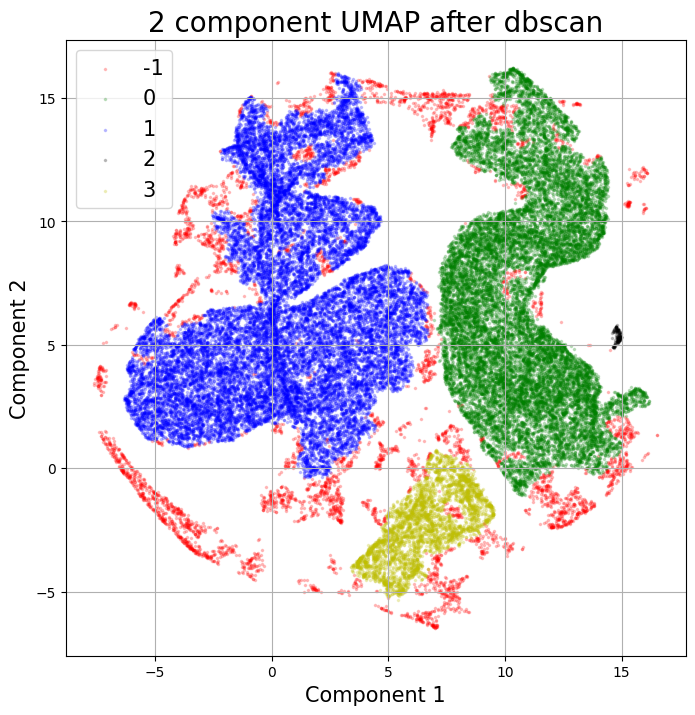

In [34]:
##DBSCAN
#best parameters
params_list=[{'eps': 0.05, 'min_samples': 50.0},
{'eps': 0.04455555555555556, 'min_samples': 50.0},
{'eps':0.2, 'min_samples': 1e4}]#last one illustrative gives only outliers as result

Dbscan=Cluster_object(DBSCAN) 

for params_db in params_list:
    Dbscan_cluster_reduced= Dbscan.cluster_fit(X_scale,params=params_db)
    #y_pred=Class_Names[Dbscan_cluster_reduced.labels_] #Since often we do not have only 3 clusters this will be out of bounds
    y_pred=Dbscan_cluster_reduced.labels_
    print(params_db, len(np.unique(y_pred)))
    
    #Dbscan_accuracy= Dbscan.score(y_pred,y) #Acuuracy harder to judge with unequal number of clusters
    labels_reduced=pd.DataFrame(y_pred,columns=['class'])
    dbscan_Df_reduced=X.join(labels_reduced)

    visualise_components('UMAP after dbscan',y_pred, dbscan_Df_reduced)
